# Estimating COVID-19's $R_t$ in Real-Time
_original code by Kevin Systrom (April 12 2020)._

In [1]:
import pandas as pd
import numpy as np
                                                                                                                                                                            
from rt_funcs import *

%config InlineBackend.figure_format = 'retina'

# Select Countries

In [2]:
all_cases = pd.read_csv("https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv")

In [3]:
# Munge

taiwan = all_cases.iloc[207 ,4:].T
taiwan.name = "Taiwan_cases"
taiwan = taiwan.reindex(pd.to_datetime(taiwan.index))

concat_ = pd.concat([get_cases(all_cases, 'Austria'),
                     get_cases(all_cases, 'Czechia'),
                     taiwan,
                     get_cases(all_cases, 'Hong Kong', column='Province/State')], axis=1)

countries = concat_.loc[pd.Timestamp('2020-03-01 00:00:00'):,:].copy()

Taking a look at the state, we need to start the analysis when there are a consistent number of cases each day. Find the last zero new case day and start on the day after that.

Also, case reporting is very erratic based on testing backlogs, etc. To get the best view of the 'true' data we can, I've applied a gaussian filter to the time series. This is obviously an arbitrary choice, but you'd imagine the real world process is not nearly as stochastic as the actual reporting.

### Running the Algorithm

Just like the example before, we create lambda based on the previous day's counts from all values of $R_t$. Unlike the previous example, I now evaluate the __log__ of the Poisson. Why? It makes windowing easier.

Since $\log{ab}=\log{a}+\log{b}$, we can do a rolling sum over the last $m$ periods and then exponentiate to get the rolling product of the original values. This does not change any of the numbers – it's just a convenience.

In [4]:
# Process data for each group

all_data_for_plot = {}

WINSIZE = 7

for j, group in enumerate(countries.columns):
    print(j+1, group)
        
    all_data_for_plot[group] = process_data(countries[group], 
                                            winsize=WINSIZE, 
                                            cases_cumulative=True)
    
    print(f"{group} processed.")

1 Austria_cases
Austria_cases processed.
2 Czechia_cases
Czechia_cases processed.
3 Taiwan_cases
Taiwan_cases processed.
4 Hong Kong_cases
Hong Kong_cases processed.


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


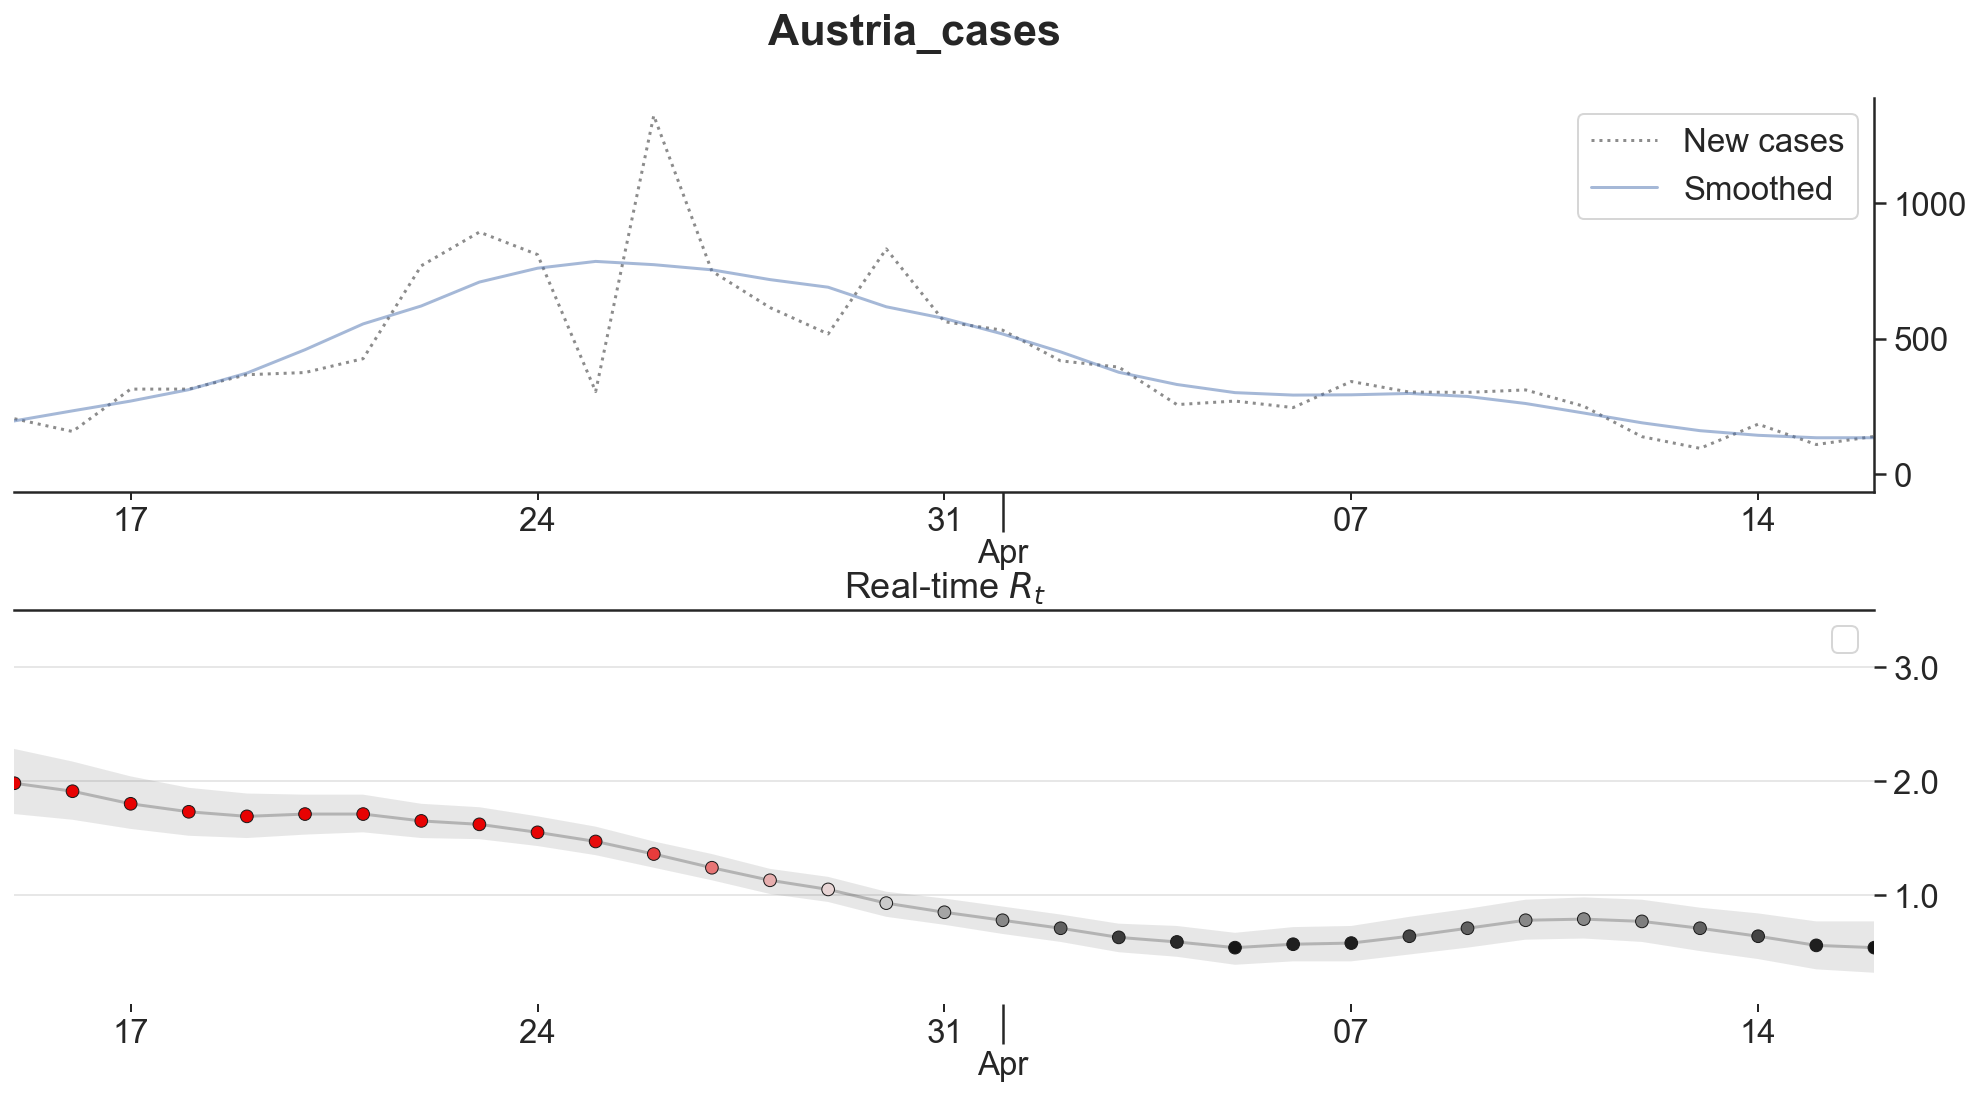

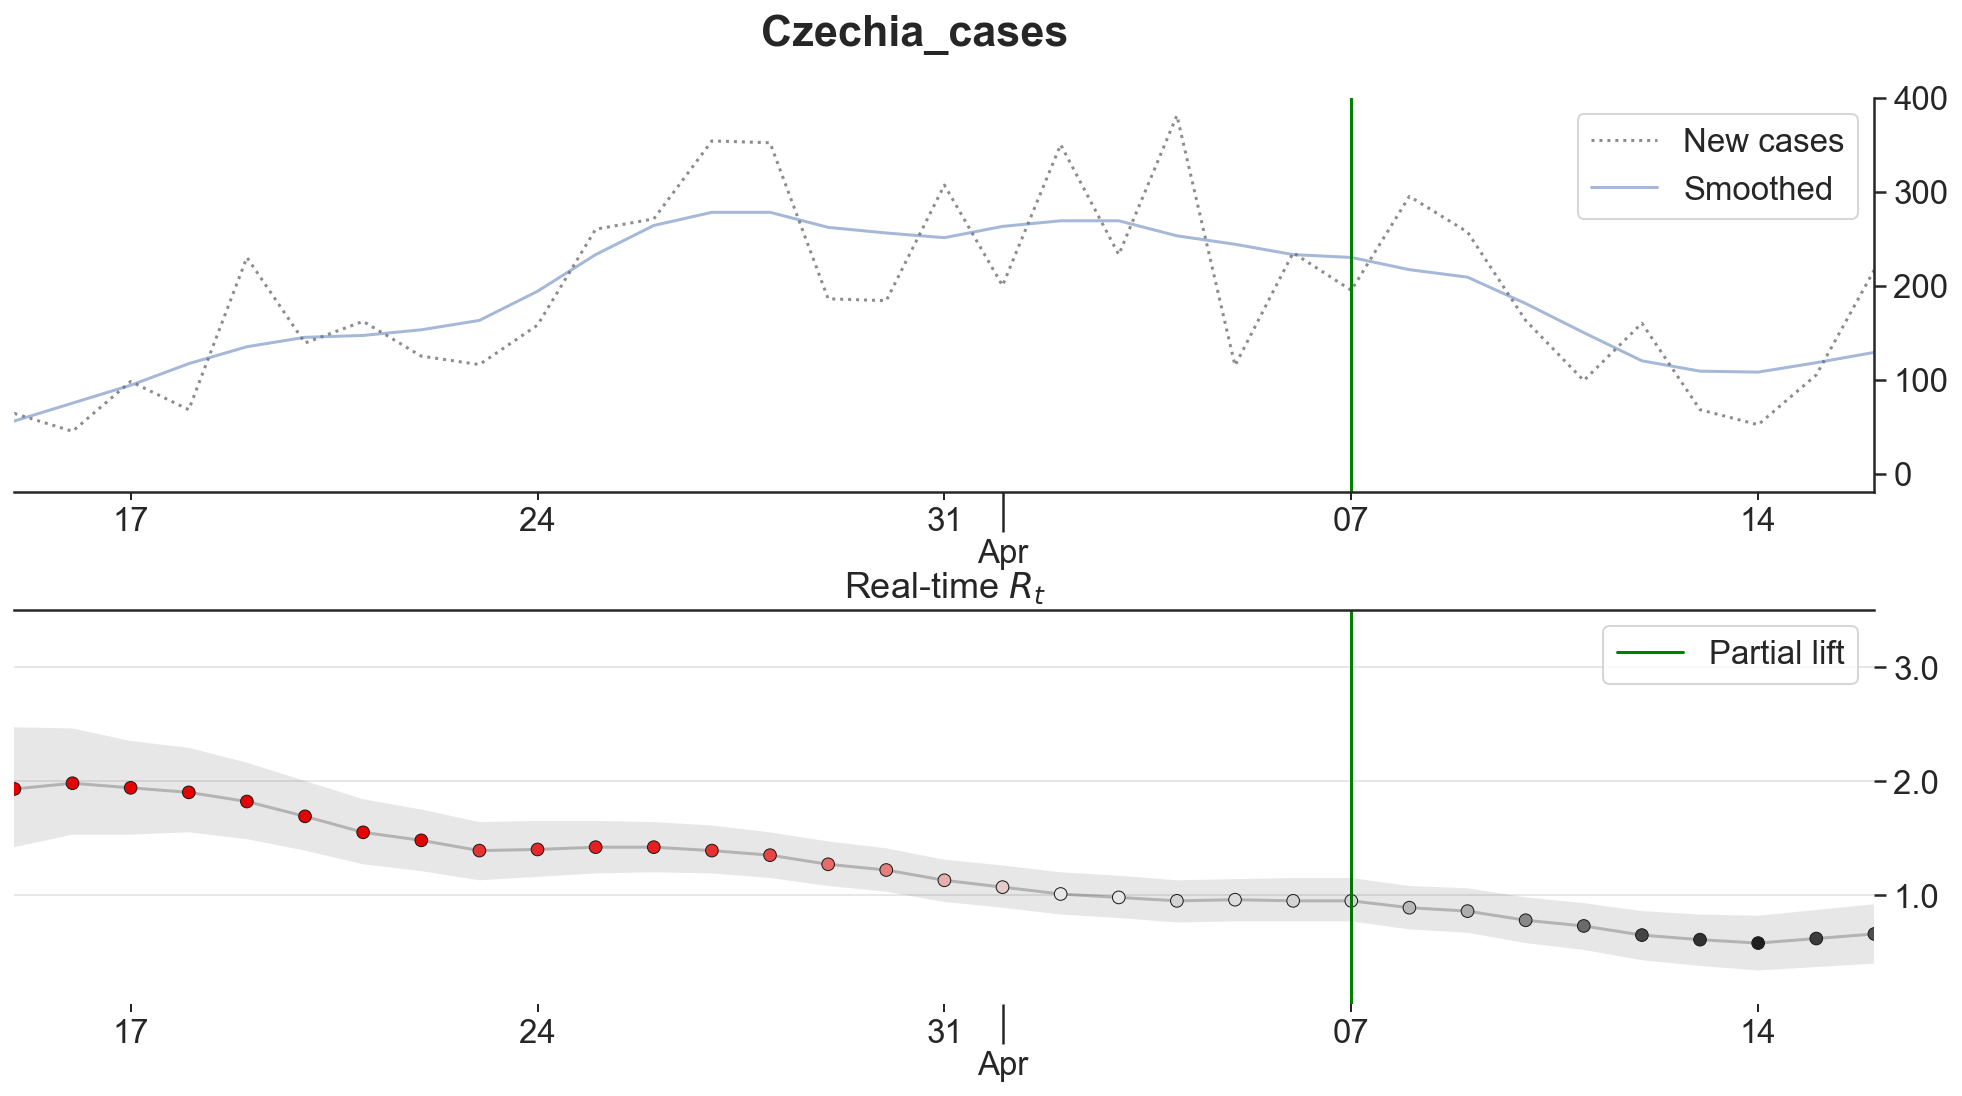

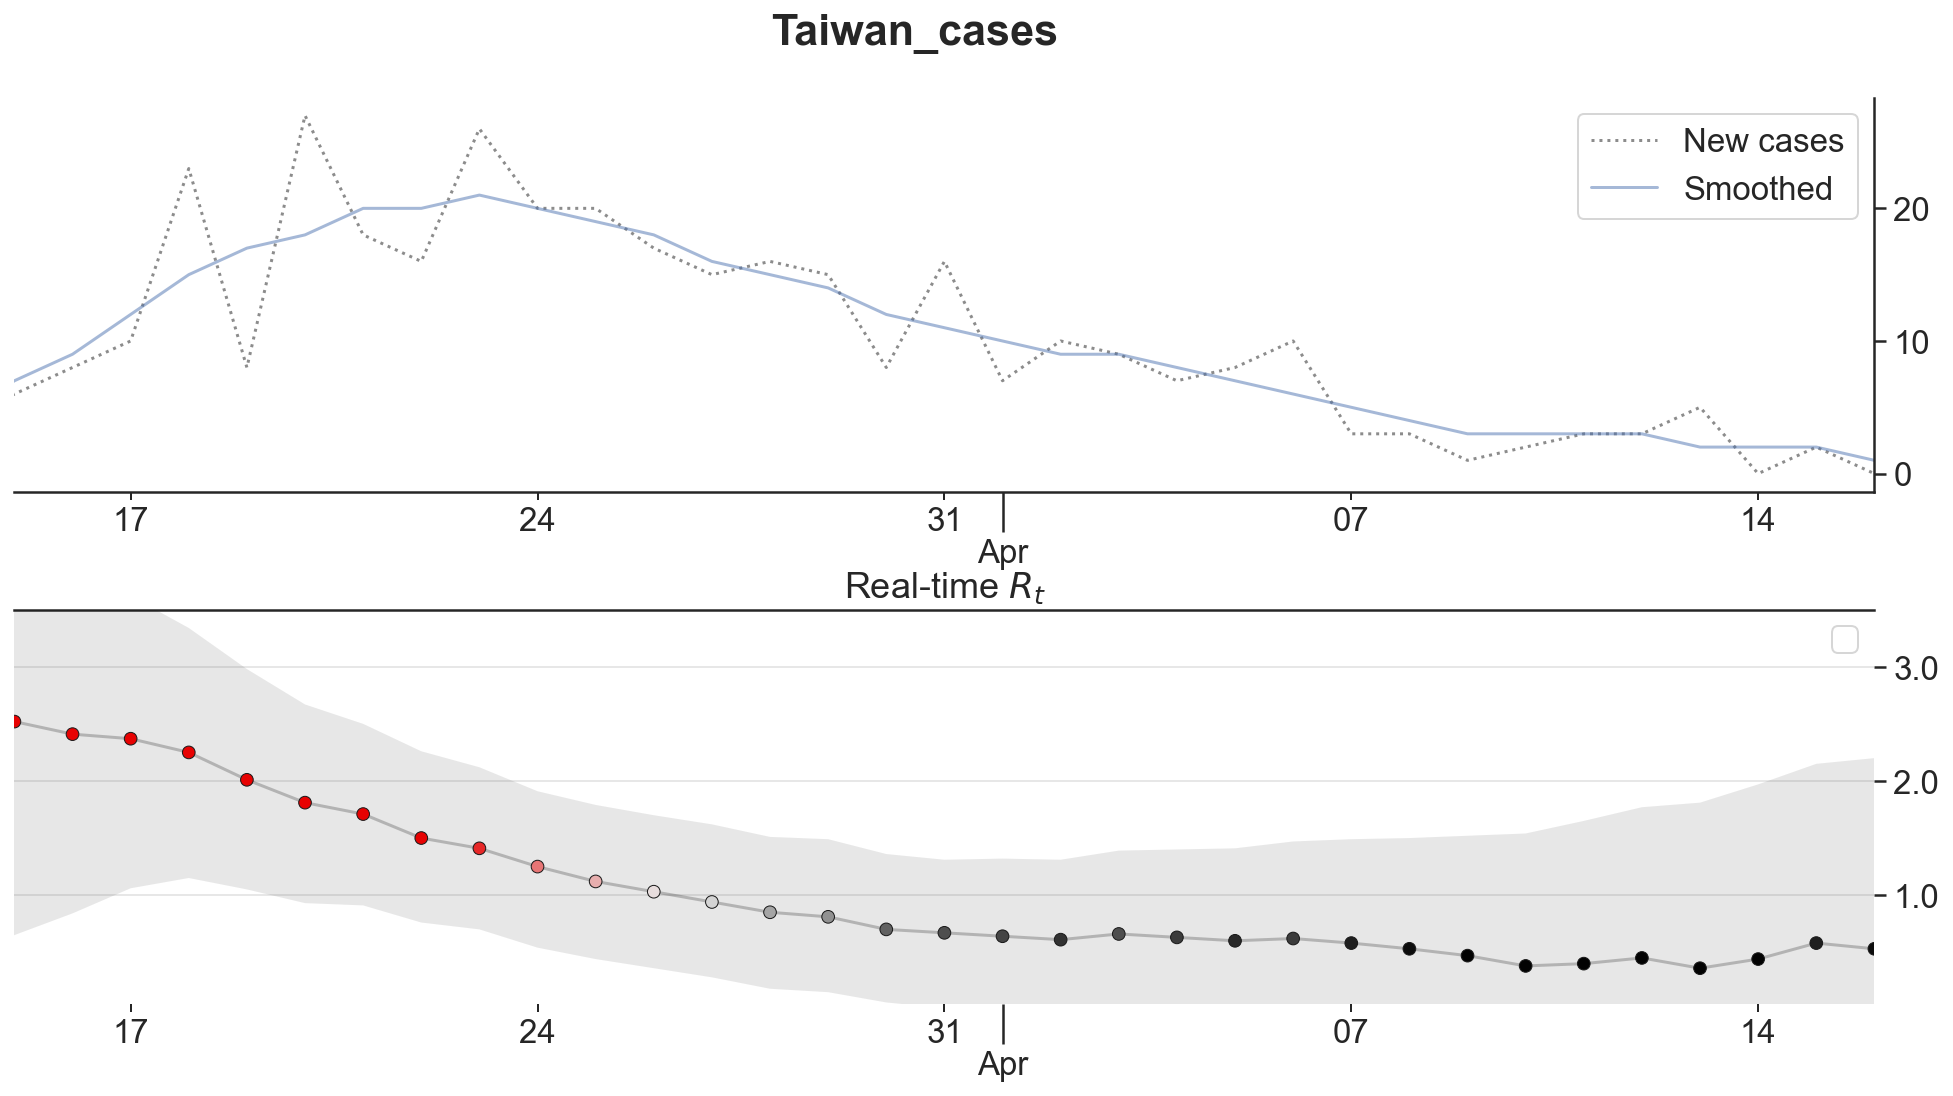

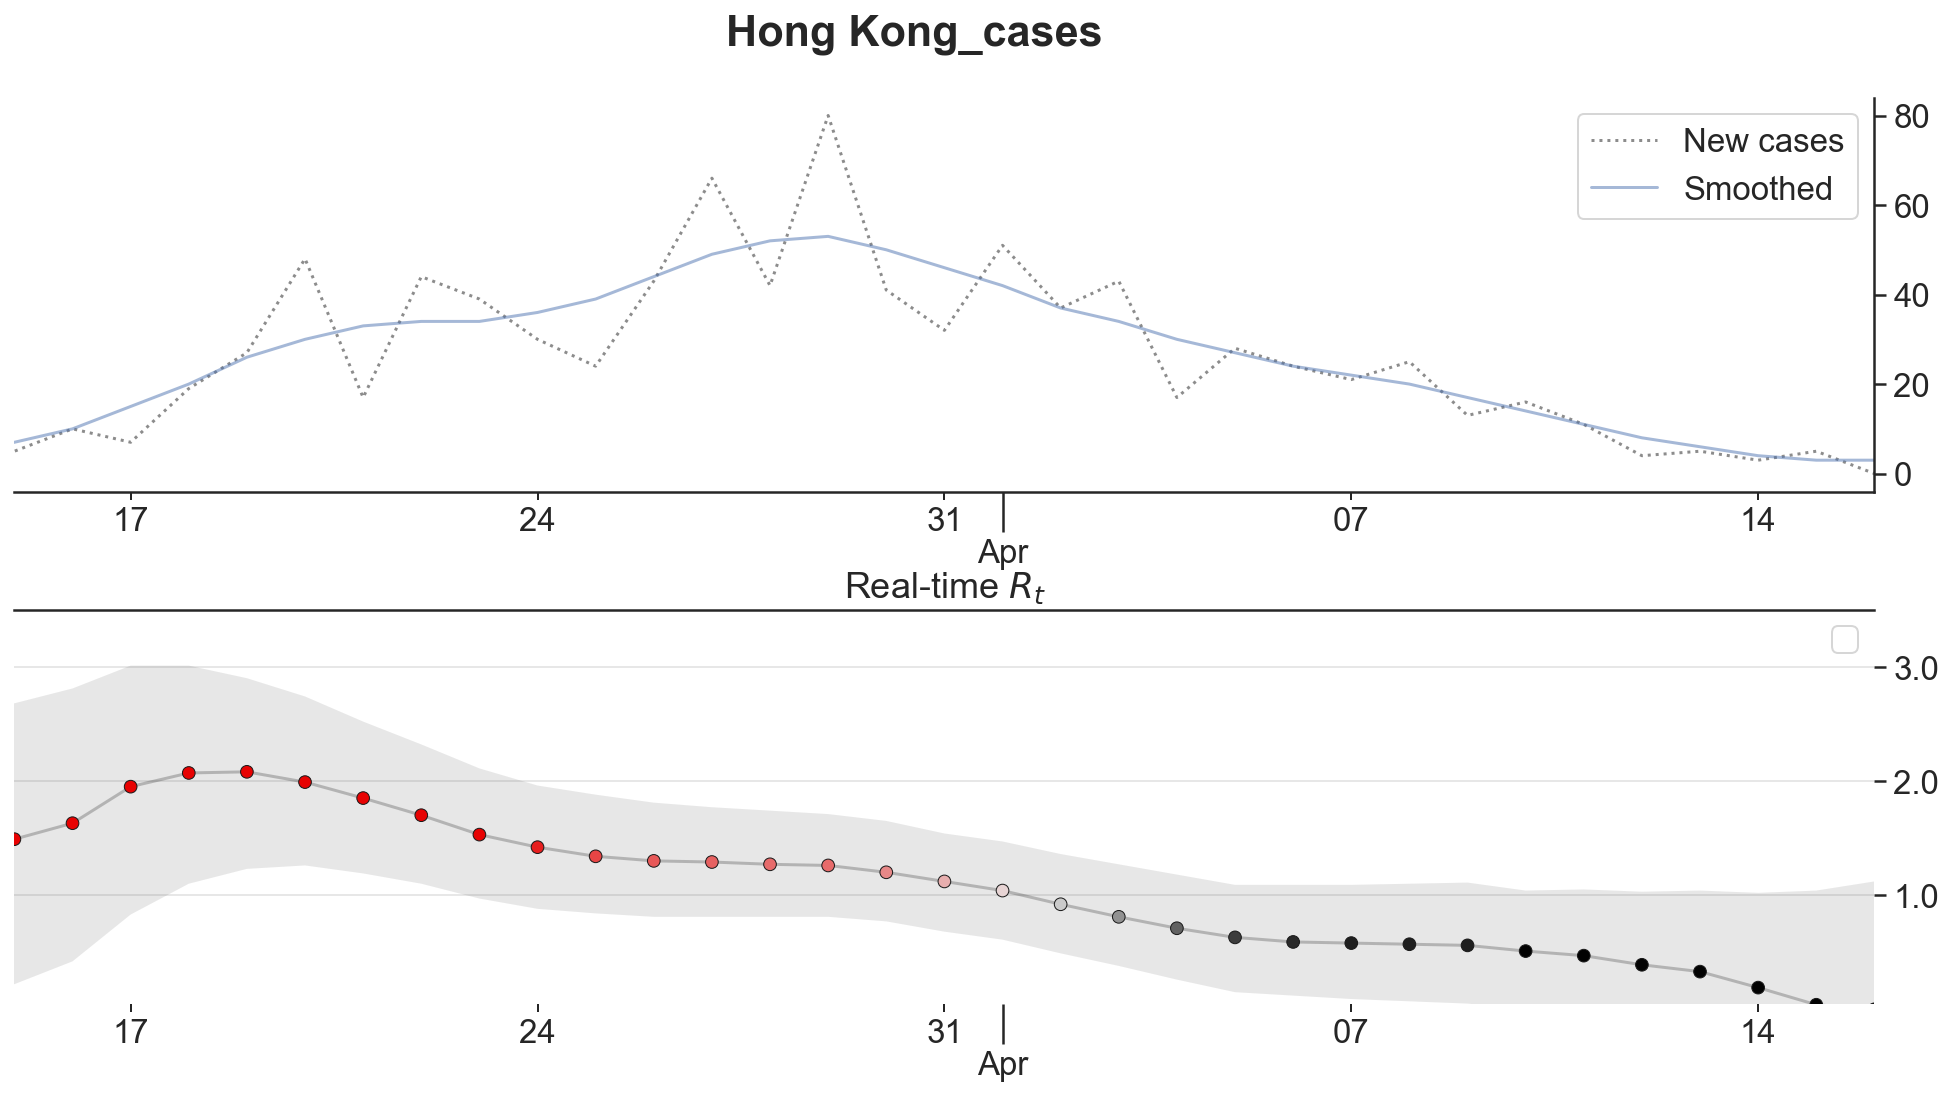

In [6]:
# Create plot.
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
import seaborn as sns
sns.set(font_scale=1.5, style="ticks")

for j, key in enumerate(all_data_for_plot.keys()):
    
    DATA = all_data_for_plot[key]
    raw = DATA['raw']
    smoothed = DATA['smoothed']
    rt = DATA['rt']
    
    f, axx = plt.subplots(nrows=2, figsize = (1200/72, 600/72),
                         gridspec_kw={"hspace": 0.3})
    

    f.suptitle(f'{key}', y=0.95, fontweight='bold')
    
    # Plot the data.
    
    axx[0].plot(raw.index, raw.values, linestyle=":", color='k', 
            zorder=1, alpha=.5, label="New cases")
    
    axx[0].plot(smoothed.index, smoothed.values, color='b',
            zorder=2, alpha=.5, label="Smoothed")
    
    axx[0].legend()
    
    sns.despine(ax=axx[0], right=False, left=True)
        
 
    
    plot_rt(rt, axx[1], "")
    
    axx[1].set_title(f'Real-time $R_t$')
    axx[1].set_ylim(.05, 3.5)
   
    
    for a in axx:
        a.set_xlim(pd.Timestamp('2020-03-15'), countries.index[-1])
        a.tick_params(axis='x', which='major', length=20)
        
        a.xaxis.set_major_locator(mdates.MonthLocator())
        a.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
        
        a.xaxis.set_minor_locator(mdates.WeekdayLocator())
        a.xaxis.set_minor_formatter(mdates.DateFormatter('%d'))
        
#         a.axvline(x=pd.Timestamp('2020-03-16'), color='orange', label='Quarantine Implemented')
        
#         if key.startswith("Austria"):
#              a.axvline(x=pd.Timestamp('2020-03-31'), color='purple', label='Masks Compulsory')
        if key.startswith("Czechia"):
             a.axvline(x=pd.Timestamp('2020-04-07'), color='green', label='Partial lift')
#                 
        axx[1].legend()
        
